# TSMixer: Retrain

### Setup

In [1]:
import sys
sys.path.append('../')
from src.load_data import *
from src.realtime_utils import *
from src.plot_functions import *
from src.hp_tuning_functions import *
import torch
from darts.utils.likelihood_models import NegativeBinomialLikelihood
from pytorch_lightning.callbacks import RichProgressBar

In [2]:
from darts.models import TSMixerModel

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/statsforecast/utils.py:231: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.


In [3]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: dwolffram (dwolffram-karlsruhe-institute-of-technology). Use `wandb login --relogin` to force relogin


True

### Configuration

In [4]:
NUM_SAMPLES = 1000
HORIZON = 4

ENCODERS = {
    'datetime_attribute': {'future': ['month', 'weekofyear']}
}

SHARED_ARGS = dict(
    output_chunk_length=HORIZON,
    likelihood=NegativeBinomialLikelihood(),
    pl_trainer_kwargs={
       "enable_progress_bar" : True,
       "enable_model_summary" : False,
       "accelerator" : "cpu",
       "callbacks" : [RichProgressBar(leave=True)]
    }
)

OPTIMIZER_DICT = {
    "Adam" : torch.optim.Adam,
    "AdamW" : torch.optim.AdamW,
    "SGD": torch.optim.SGD
}

# Load best model

In [5]:
params = get_best_parameters('realtime-tsmixer-expanding-window', 'tsmixer', 'WIS_2022', sweep='h7m4oeqg')

WIS_2022 of best run: 376.81822673712344


In [6]:
params

{'model': 'tsmixer',
 'dropout': 0.3,
 'ff_size': 32,
 'n_epochs': 1000,
 'norm_type': 'TimeBatchNorm2d',
 'optimizer': 'AdamW',
 'activation': 'ReLU',
 'batch_size': 32,
 'num_blocks': 10,
 'hidden_size': 32,
 'use_encoders': True,
 'use_features': False,
 'sample_weight': 'linear',
 'use_covariates': False,
 'normalize_before': False,
 'optimizer_kwargs': {'lr': 0.0005, 'weight_decay': 0},
 'input_chunk_length': 8,
 'use_static_covariates': False}

In [7]:
name = params.pop('model')
use_covariates = params.pop('use_covariates')
use_features = params.pop('use_features')
use_encoders = params.pop('use_encoders')
optimizer = params.pop('optimizer')
sample_weight = params.pop('sample_weight')

params['optimizer_cls'] = OPTIMIZER_DICT[optimizer]

# Load data

In [8]:
targets, covariates = load_realtime_training_data()

In [9]:
targets_train, targets_validation = train_validation_split(targets, 2023)

<Axes: xlabel='date'>

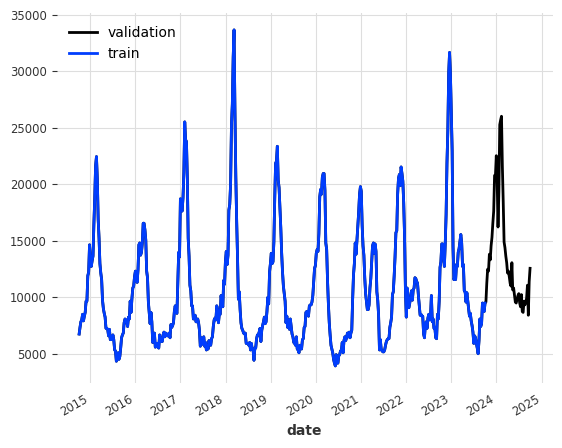

In [10]:
targets_validation['icosari-sari-DE'].plot(label='validation')
targets_train['icosari-sari-DE'].plot(label='train')

In [11]:
forecast_dates = sorted([filename.split('/')[-1][:10] for filename in glob.glob('../data/nowcasts/KIT-baseline/*.csv')])

In [12]:
forecast_dates = [f for f in forecast_dates if f >= '2023-11-16' and f <= '2024-09-12']

# Train model

In [16]:
RANDOM_SEEDS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [17]:
forecast_dates[:4]

['2023-11-16', '2023-11-23', '2023-11-30', '2023-12-07']

In [ ]:
for forecast_date in forecast_dates[:4]:
    
    path = f'../models/post-covid/{forecast_date}/'
    os.makedirs(path, exist_ok=True)

    targets, covariates = load_realtime_training_data(as_of=forecast_date)

    for seed in RANDOM_SEEDS:
        model_path = path + f'{forecast_date}-tsmixer_retrain-{seed}.pt'
        print(model_path)
        model = TSMixerModel(
            **params,
            add_encoders=ENCODERS if use_encoders else None,
            **SHARED_ARGS,
            random_state=seed
        )
        model.fit(targets, past_covariates=covariates if use_covariates else None, sample_weight=sample_weight)
        model.save(model_path)

Epoch 507/999 ━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━ 10/15 0:00:00 • 0:00:01 19.05it/s train_loss: 3.849 

# Forecast

In [13]:
RANDOM_SEEDS = [1, 2, 3, 4, 5 , 6, 7, 8, 9, 10]

In [14]:
NAME = 'tsmixer_retrain'

In [15]:
#forecast_dates = sorted([filename.split('/')[-1][:10] for filename in glob.glob('../data/nowcasts/KIT-baseline/*.csv')])

In [16]:
targets, covariates = load_realtime_training_data()

In [17]:
def compute_ensemble(forecast_date, export=False):
    dfs = []
    for seed in RANDOM_SEEDS:
        print(seed)
        model_path = f'../models/post-covid/{forecast_date}/{forecast_date}-tsmixer_retrain-{seed}.pt'
        model = TSMixerModel.load(model_path)
        df = compute_forecast(model, targets, covariates if use_covariates else None, forecast_date, HORIZON, NUM_SAMPLES, vincentization=False, probabilistic_nowcast=True, local=True)
        dfs.append(df)

    df = pd.concat(dfs)
    df = df.groupby(['location', 'age_group', 'forecast_date', 'target_end_date', 'horizon', 'type', 'quantile']).agg({'value': 'mean'}).reset_index()

    df = df.sort_values(['location', 'age_group', 'horizon', 'quantile'])
    
    if export:
        df.to_csv(f'../data/post-covid/submissions/{NAME}/{forecast_date}-icosari-sari-{NAME}.csv', index=False)
        return df
    else:
        return df

In [28]:
# df = compute_ensemble(forecast_dates[5])

Predicting ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 0:00:06 • 0:00:00 0.88it/s

2



KeyboardInterrupt



In [ ]:
forecasts = []
for forecast_date in forecast_dates[:4]:
    print(forecast_date)
    forecast = compute_ensemble(forecast_date, export=True)
    forecasts.append(forecast)

Predicting ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/2 0:00:00 • -:--:-- 0.00it/s

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
